# Large-scale multi-label text classification

**Author:** [Sayak Paul](https://twitter.com/RisingSayak), [Soumik Rakshit](https://github.com/soumik12345)<br>
**Date created:** 2020/09/25<br>
**Last modified:** 2020/12/23<br>
**Description:** Implementing a large-scale multi-label text classification model.

## Introduction

In this example, we will build a multi-label text classifier to predict the subject areas
of arXiv papers from their abstract bodies. This type of classifier can be useful for
conference submission portals like [OpenReview](https://openreview.net/). Given a paper
abstract, the portal could provide suggestions for which areas the paper would
best belong to.

The dataset was collected using the
[`arXiv` Python library](https://github.com/lukasschwab/arxiv.py)
that provides a wrapper around the
[original arXiv API](http://arxiv.org/help/api/index).
To learn more about the data collection process, please refer to
[this notebook](https://github.com/soumik12345/multi-label-text-classification/blob/master/arxiv_scrape.ipynb).
Additionally, you can also find the dataset on
[Kaggle](https://www.kaggle.com/spsayakpaul/arxiv-paper-abstracts).

## Imports

In [2]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Perform exploratory data analysis

In this section, we first load the dataset into a `pandas` dataframe and then perform
some basic exploratory data analysis (EDA).

In [6]:
arxiv_data = pd.read_csv(
    "/Users/chinmaykh/Documents/GitHub/WhyNotVax/data/train_val_cleaned.csv"
)
arxiv_data.head()

,ID,tweet,labels
0,1296010336907038720t,AstraZeneca is made with the kidney cells of ...,ingredients
1,1336808189677940736t,It begins Please find safe alternatives to thi...,side-effect
2,1329488407307956231t,Well I mean congratulations Covid19 for being...,side-effect
3,1364194604459900934t,for those of us that do not wish a vaccine so...,mandatory
4,1375938799247765515t,She has been trying to speak out writing lette...,side-effect rushed


Our text features are present in the `tweet` column and their corresponding labels
are in `labels`. As you can notice, there are multiple categories associated with a
particular entry.

In [7]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 9921 rows in the dataset.


Real-world data is noisy. One of the most commonly observed source of noise is data
duplication. Here we notice that our initial dataset has got about 13k duplicate entries.

In [8]:
total_duplicate_ID = sum(arxiv_data["ID"].duplicated())
print(f"There are {total_duplicate_ID} duplicate ID.")

There are 0 duplicate ID.


Before proceeding further, we drop these entries.

In [9]:
arxiv_data = arxiv_data[~arxiv_data["ID"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some labels with occurrence as low as 1.
print(sum(arxiv_data["labels"].value_counts() == 1))

# How many unique labels?
print(arxiv_data["labels"].nunique())

There are 9921 rows in the deduplicated dataset.
131
288


As observed above, out of 3,157 unique combinations of `labels`, 2,321 entries have the
lowest occurrence. To prepare our train, validation, and test sets with
[stratification](https://en.wikipedia.org/wiki/Stratified_sampling), we need to drop
these labels.

In [10]:
# Filtering the rare labels.
arxiv_data_filtered = arxiv_data.groupby("labels").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(9790, 3)

## Convert the string labels to lists of strings

The initial labels are represented as raw strings. Here we make them `List[str]` for a
more compact representation.

In [11]:
arxiv_data_filtered["labels"] = arxiv_data_filtered["labels"].apply(
    lambda x: x.split(" ")
)
arxiv_data_filtered["labels"].values[:5]

array([list(['ingredients']), list(['side-effect']),
       list(['side-effect']), list(['mandatory']),
       list(['side-effect', 'rushed'])], dtype=object)

## Use stratified splits because of class imbalance

The dataset has a
[class imbalance problem](https://developers.google.com/machine-learning/glossary/#class-imbalanced-dataset).
So, to have a fair evaluation result, we need to ensure the datasets are sampled with
stratification. To know more about different strategies to deal with the class imbalance
problem, you can follow
[this tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
For an end-to-end demonstration of classification with imbablanced data, refer to
[Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/).

In [12]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["labels"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 8811
Number of rows in validation set: 490
Number of rows in test set: 489


## Multi-label binarization

Now we preprocess our labels using the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer.

In [13]:
labels = tf.ragged.constant(train_df["labels"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(labels)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab labels."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'side-effect', 'ineffective', 'rushed', 'pharma', 'mandatory', 'unnecessary', 'none', 'political', 'conspiracy', 'ingredients', 'country', 'religious']


Here we are separating the individual unique classes available from the label
pool and then using this information to represent a given label set with 0's and 1's.
Below is an example.

In [14]:
sample_label = train_df["labels"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['ingredients']
Label-binarized representation: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


## Data preprocessing and `tf.data.Dataset` objects

We first get percentile estimates of the sequence lengths. The purpose will be clear in a
moment.

In [15]:
train_df["tweet"].apply(lambda x: len(x.split(" "))).describe()

count    8811.000000
mean       34.685280
std        12.476158
min         3.000000
25%        24.000000
50%        36.000000
75%        45.000000
max        87.000000
Name: tweet, dtype: float64

Notice that 50% of the abstracts have a length of 154 (you may get a different number
based on the split). So, any number close to that value is a good enough approximate for the
maximum sequence length.

Now, we implement utilities to prepare our datasets.

In [16]:
max_seqlen = 36
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["labels"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["tweet"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


Now we can prepare the `tf.data.Dataset` objects.

In [17]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Dataset preview

In [18]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b' Only Pakistan will use Chinese vaccine with Neurological side effects Peru found out how bad is Chinese vaccine '
Label(s): ['side-effect']
 
Abstract: b'People have been dying from the covid vaccine but people are still getting vaccinated because they want things to go back to normal and its the only way a shit show '
Label(s): ['ineffective']
 
Abstract: b'Im torn about getting the COVID19 vaccine I do want to get it but not right now I want to see how this vaccine affects Black people since historically these medical testsvaccine were not made to suit us Is this a valid concern'
Label(s): ['rushed']
 
Abstract: b'  So a mandatory vaccine will be required for a manmade virus which potentially kills on average 11 of the population Can you share the demographic of the fatalities also for clarity please'
Label(s): ['mandatory']
 
Abstract: b'Agreed Its very important to write to your doctor advising that the Pfizer are unaware of the effects on fertility or the effect the v

## Vectorization

Before we feed the data to our model, we need to vectorize it (represent it in a numerical form).
For that purpose, we will use the
[`TextVectorization` layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).
It can operate as a part of your main model so that the model is excluded from the core
preprocessing logic. This greatly reduces the chances of training / serving skew during inference.

We first calculate the number of unique words present in the abstracts.

In [19]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["tweet"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)


16862


We now create our vectorization layer and `map()` to the `tf.data.Dataset`s created
earlier.

In [20]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=3, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


A batch of raw text will first go through the `TextVectorization` layer and it will
generate their integer representations. Internally, the `TextVectorization` layer will
first create bi-grams out of the sequences and then represent them using
[TF-IDF](https://wikipedia.org/wiki/Tf%E2%80%93idf). The output representations will then
be passed to the shallow model responsible for text classification.

To learn more about other possible configurations with `TextVectorizer`, please consult
the
[official documentation](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).

**Note**: Setting the `max_tokens` argument to a pre-calculated vocabulary size is
not a requirement.

## Create a text classification model

We will keep our model simple -- it will be a small stack of fully-connected layers with
ReLU as the non-linearity.

In [21]:

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model


## Train the model

We will train our model using the binary crossentropy loss. This is because the labels
are not disjoint. For a given abstract, we may have multiple categories. So, we will
divide the prediction task into a series of multiple binary classification problems. This
is also why we kept the activation function of the classification layer in our model to
sigmoid. Researchers have used other combinations of loss function and activation
function as well. For example, in [Exploring the Limits of Weakly Supervised Pretraining](https://arxiv.org/abs/1805.00932),
Mahajan et al. used the softmax activation function and cross-entropy loss to train
their models.

There are several options of metrics that can be used in multi-label classification.
To keep this code example narrow we decided to use the
[binary accuracy metric](https://keras.io/api/metrics/accuracy_metrics/#binaryaccuracy-class).
To see the explanation why this metric is used we refer to this
[pull-request](https://github.com/keras-team/keras-io/pull/1133#issuecomment-1322736860).
There are also other suitable metrics for multi-label classification, like
[F1 Score](https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score) or
[Hamming loss](https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/HammingLoss).

Epoch 1/20
69/69 [==============================] - 6s 69ms/step - loss: 0.2560 - binary_accuracy: 0.9207 - val_loss: 0.1995 - val_binary_accuracy: 0.9323
Epoch 2/20
69/69 [==============================] - 4s 63ms/step - loss: 0.0784 - binary_accuracy: 0.9739 - val_loss: 0.2221 - val_binary_accuracy: 0.9298
Epoch 3/20
69/69 [==============================] - 4s 57ms/step - loss: 0.0222 - binary_accuracy: 0.9949 - val_loss: 0.2803 - val_binary_accuracy: 0.9303
Epoch 4/20
69/69 [==============================] - 4s 61ms/step - loss: 0.0073 - binary_accuracy: 0.9991 - val_loss: 0.3261 - val_binary_accuracy: 0.9292
Epoch 5/20
69/69 [==============================] - 4s 58ms/step - loss: 0.0036 - binary_accuracy: 0.9997 - val_loss: 0.3480 - val_binary_accuracy: 0.9300
Epoch 6/20
69/69 [==============================] - 5s 66ms/step - loss: 0.0024 - binary_accuracy: 0.9997 - val_loss: 0.3799 - val_binary_accuracy: 0.9305
Epoch 7/20
69/69 [==============================] - 6s 82ms/step - los

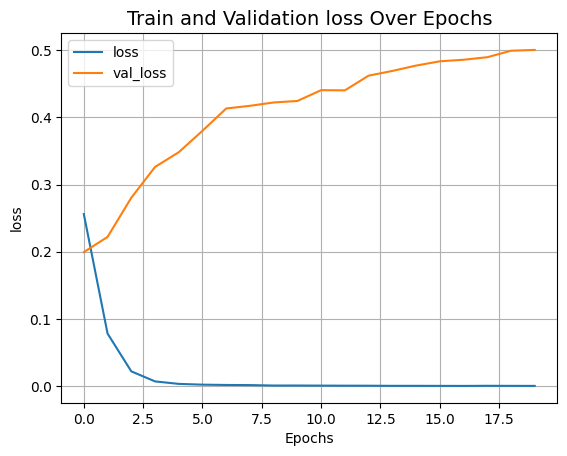

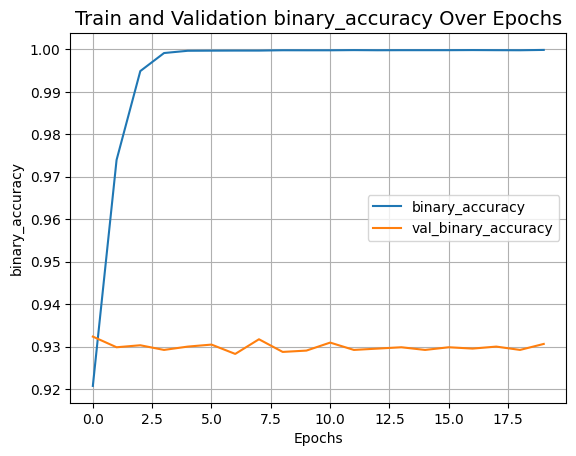

In [22]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

While training, we notice an initial sharp fall in the loss followed by a gradual decay.

### Evaluate the model

In [23]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

4/4 [==============================] - 0s 22ms/step - loss: 0.5069 - binary_accuracy: 0.9347
Categorical accuracy on the test set: 93.47%.


The trained model gives us an evaluation accuracy of ~99%.

## Inference

An important feature of the
[preprocessing layers provided by Keras](https://keras.io/guides/preprocessing_layers/)
is that they can be included inside a `tf.keras.Model`. We will export an inference model
by including the `text_vectorization` layer on top of `shallow_mlp_model`. This will
allow our inference model to directly operate on raw strings.

**Note** that during training it is always preferable to use these preprocessing
layers as a part of the data input pipeline rather than the model to avoid
surfacing bottlenecks for the hardware accelerators. This also allows for
asynchronous data processing.

In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)
y_pred = []
# Perform inference.
for i, text in enumerate(text_batch):
    label = label_batch[i].numpy()[None, ...]
    #if(len(invert_multi_hot(label[0])) == 3):
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        (h, x)
        for h, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    #print(top_3_labels)
    #delete 0.1 from each ele
    top_3_labels = [x for h, x in top_3_labels if h > 0.1]
    #print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")
    if len(top_3_labels) == 0:
        y_pred.append(["none"])
    else:
        y_pred.append(list(top_3_labels))

print(y_pred)

In [26]:
# Now, we add the predictions to our dataframe
df = pd.read_csv('/Users/chinmaykh/Documents/GitHub/WhyNotVax/test_data/test.csv')
df.head()

,id,tweet
0,1070378532260470789t,Study Links HPV Vaccine to Historically High I...
1,973746711964372993t,Deaths from tainted measles vaccine affecting ...
2,1043031076787040257t,"Am apreciat un videoclip pe @YouTube, https://..."
3,1066338147527741440t,VIDEO --&gt;&gt; MMR #Vaccine increase risk of...
4,963522018544152576t,Oral Polio Vaccine: Infecting Unvaccinated Kid...


In [136]:
def predict(s):
    probs = model_for_inference.predict([s])
    top_3_labels = [
        (h, x)
        for h, x in sorted(
            zip(*probs, lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(top_3_labels)
    if len(top_3_labels) == 0: 
        return "none"
    sfsf = " ".join([x[1] for x  in filter(lambda x: x[0] > 0.1, top_3_labels)])
    if sfsf == "": 
        return "none"
    return sfsf

predict('I am cool')

1/1 [==============================] - 0s 130ms/step
[(0.63994294, 'none'), (0.22199897, 'unnecessary'), (0.12095791, 'pharma')]


'none unnecessary pharma'

In [137]:
# Create a new column in the dataframe
df['labels'] = df['tweet']

# Iterate over the rows of the dataframe, and for each row, calculate the predict and store it in the new column
for index, row in df.iterrows():
    print(index, row['tweet'])
    df.loc[index, 'labels'] = predict(row['tweet'])

0 Study Links HPV Vaccine to Historically High Infertility Rates https://t.co/u0gVeqotao #Spirituality #Self
1/1 [==============================] - 0s 61ms/step
[(0.14110851, 'side-effect'), (0.11690179, 'pharma'), (0.062550806, 'mandatory')]
1 Deaths from tainted measles vaccine affecting anti-polio drive https://t.co/BJDu2geA8z https://t.co/G3woUPVilV
1/1 [==============================] - 0s 44ms/step
[(0.99884784, 'side-effect'), (0.033287685, 'religious'), (0.028598174, 'ingredients')]
2 Am apreciat un videoclip pe @YouTube, https://t.co/UknVKyPp3W Treatment and Cure For Gardasil HPV Vaccine Injury Here is Leyla's Story
1/1 [==============================] - 0s 53ms/step
[(0.99993175, 'side-effect'), (1.6700642e-05, 'ineffective'), (6.7298133e-06, 'conspiracy')]
3 VIDEO --&gt;&gt; MMR #Vaccine increase risk of #AUTISM in #AfricanAmerican Community WATCH HERE --&gt;&gt; https://t.co/9yOyieOLwa https://t.co/X4FRxLBtMq
1/1 [==============================] - 0s 34ms/step
[(0.9994108, 

In [138]:
# Save it to test/submission.csv
df.to_csv('submission.csv', index=False)

The prediction results are not that great but not below the par for a simple model like
ours. We can improve this performance with models that consider word order like LSTM or
even those that use Transformers ([Vaswani et al.](https://arxiv.org/abs/1706.03762)).

## Acknowledgements

We would like to thank [Matt Watson](https://github.com/mattdangerw) for helping us
tackle the multi-label binarization part and inverse-transforming the processed labels
to the original form.

Thanks [Cingis Kratochvil](https://github.com/cumbalik) for suggesting and extending
this code example by the binary accuracy.